# Preprocessing before spam detection

Later, we will use a MLP to do text classification. Before trainig, we must prepare the date. Let's do this

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # conda install -c anaconda pandas

#Deep learning 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

#Text processing
import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the data

In [58]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection" #Use the RAW one
df = pd.read_csv(url, sep ='\t', names=["label", "message"])
df

label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [59]:
df.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

# Let's explore the proportion of ham and spam messages

Let's do some plot to compare the most frequent lengths of the text data.

In [60]:
df['length'] = df['message'].apply(len)
df.head()

label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61

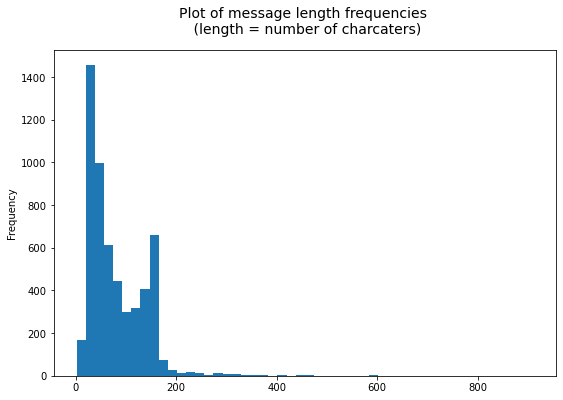

In [61]:
df['length'].plot.hist(bins = 50, figsize = (9,6))
plt.title("Plot of message length frequencies \n (length = number of charcaters)", fontsize=14, y=1.03)
plt.savefig('length_freq.png', dpi=300)

Let's do the same by separating ham and spam message.

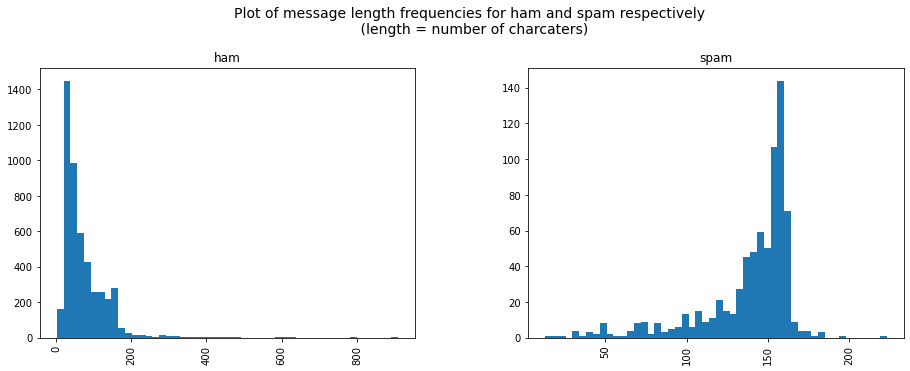

In [62]:
df.hist(column = 'length',by = 'label', bins = 50, figsize = (15,5))
plt.suptitle("Plot of message length frequencies for ham and spam respectively \n (length = number of charcaters)",
            y=1.07, fontsize=14)
plt.savefig('length_freq_ham_spam.png', dpi=300,bbox_inches = 'tight')

# Exploratory data analysis : visualization

The idea of visualization comes from the following website : 
https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472

As we haven't cleaned the data yet, we do not expect this tool to be as representative as on cleaned data. We'll compare this later.

### Wordcloud

In [63]:
from wordcloud import WordCloud, STOPWORDS  # conda install -c conda-forge wordcloud

In [64]:
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']

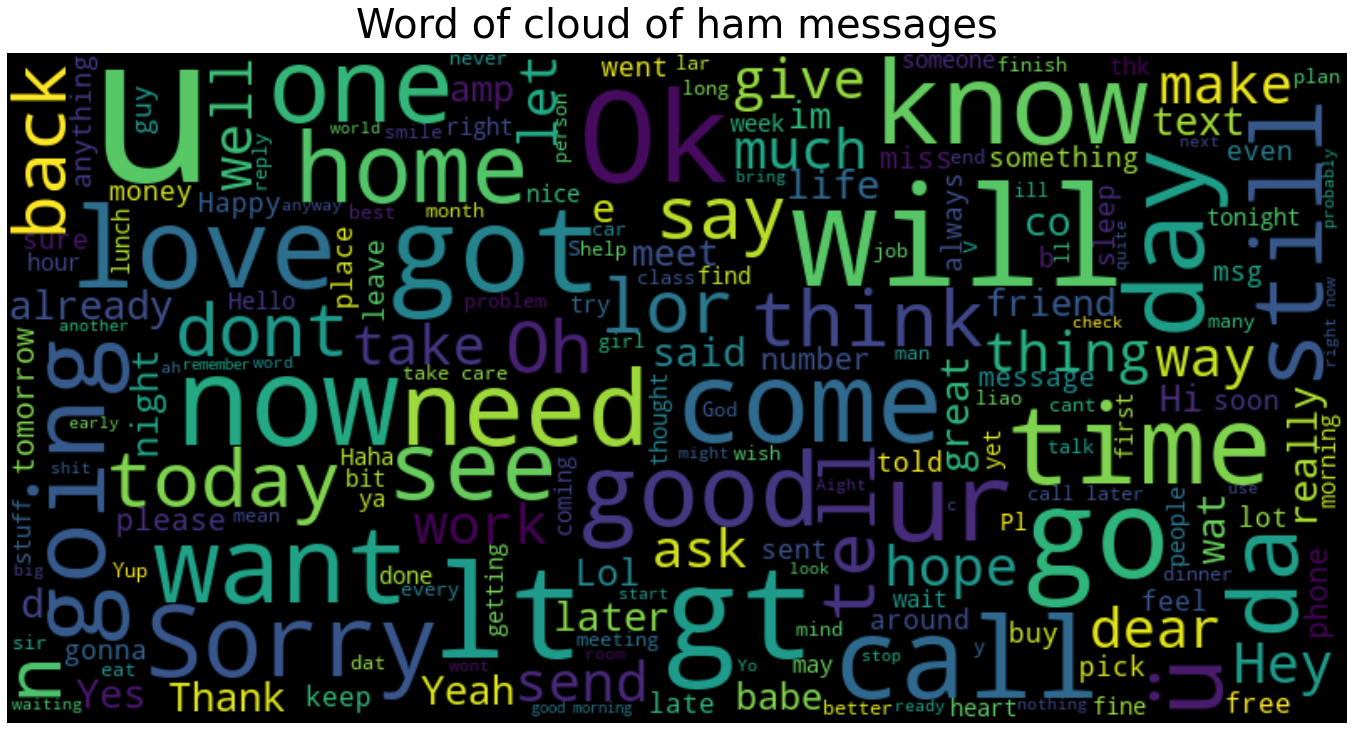

In [65]:
# create a text with all the messages
hamText = " ".join(review for review in ham_msg.message) #df.message)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='black',
                    #stopwords = stopwords,
                    max_words = 200,
                    max_font_size = 125, 
                    random_state = 42,
                    width=800, 
                    height=400)
wordcloud.generate(str(hamText))

# Display the generated image:
plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word of cloud of ham messages", fontdict={'size': 40, 'verticalalignment': 'bottom'})
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("img/first_review.png")

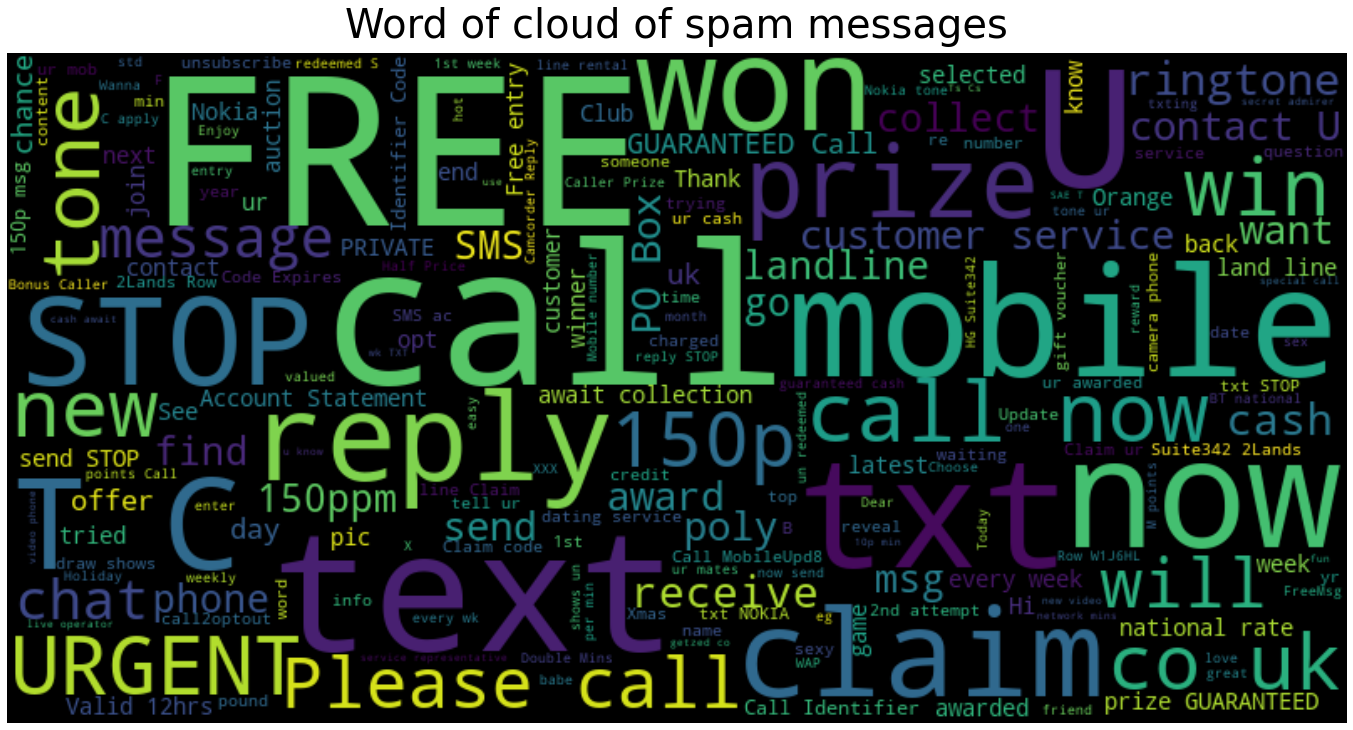

In [66]:
# create a text with all the messages
spamText = " ".join(review for review in spam_msg.message) #df.message)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='black',
                    #stopwords = stopwords,
                    max_words = 200,
                    max_font_size = 125, 
                    random_state = 42,
                    width=800, 
                    height=400)
wordcloud.generate(str(spamText))

# Display the generated image:
plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word of cloud of spam messages", fontdict={'size': 40, 'verticalalignment': 'bottom'})
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("img/first_review.png")

### N-grams

In [67]:
import nltk
from nltk.util import ngrams

#%matplotlib inline
from plotly import tools #  conda install -c plotly plotly=5.7.0 
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
#%matplotlib

Let's begin by a 1-gram plot.

In [68]:
# generate n grams
def gen_ngrams(message, n_gram=1):
    lis = []
    for elem in ngrams(message.split(' '), n_gram):
        lis.append(' '.join(str(i) for i in elem))
    return lis

def f(y):
    return y[1]

# create a dataframe with the n-grams of the text 
def create_df(text, n):
    dico = dict()
    for msg in text:
        for i in gen_ngrams(msg, n):
            if(dico.get(i) == None):
                dico[i]=1
                continue
            dico[i] += 1
    df = pd.DataFrame(sorted(dico.items(), key = f)[::-1])
    df.columns = ["message", "number"]
    return df #horizontal_bar_chart(temp.head(nbMostFreq), 'blue')

# create 2 subplots
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Frequent words of ham messages", 
                                                          "Frequent words of spam messages"])
fig.append_trace(go.Bar(
            y = create_df(ham_msg.message, 1)["message"].head(30).values[::-1],
            x = create_df(ham_msg.message, 1)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 1)
fig.append_trace(go.Bar(
            y = create_df(spam_msg.message, 1)["message"].head(30).values[::-1],
            x = create_df(spam_msg.message, 1)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 2)

fig['layout'].update(height=1200, width=900, title="Plots of words frequences",  title_x=0.6, title_y=0.84)
fig.show()
#py.iplot(fig)

#plt.figure(figsize=(10,16))
#plt.show()

C:\Users\remac\Anaconda3\envs\DL_projet\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Let's do a 2-gram plot.

In [69]:
# create 2 subplots
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Bigram of frequent ham messages", 
                                                          "Bigram of frequent spam messages"])
fig.append_trace(go.Bar(
            y = create_df(ham_msg.message, 2)["message"].head(30).values[::-1],
            x = create_df(ham_msg.message, 2)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 1)
fig.append_trace(go.Bar(
            y = create_df(spam_msg.message, 2)["message"].head(30).values[::-1],
            x = create_df(spam_msg.message, 2)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 2)

fig['layout'].update(height=1200, width=900, title="Bigrams of words frequences",  title_x=0.5, title_y=0.96)
fig.show()
#py.iplot(fig)

#plt.figure(figsize=(10,16))
#plt.show()

C:\Users\remac\Anaconda3\envs\DL_projet\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Preparing the data

### Data cleaning

Text cleaning :
Before working on the data, one can remove some information as urls, emoji, numbers, punctuation, etc. One can also change the words to lowercase. Some words, such as "the" or "and", are very frequent but not useful to determine if the text is spam or not. These words are called "stopwords" and one can get rid of them.

In [70]:
import re
import string
from sklearn.feature_extraction import _stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\remac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\remac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\remac\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
# let's create a fonction to clean the data
def clean_data(text):
    # remove urls, numbers and punctuation
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans(dict.fromkeys(string.punctuation)))
        
    # change to lowercase
    text = text.lower()
        
    # remove multiple spaces and replace by single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
        
    # remove newlines, special characters and single characters
    text = text.replace('\n','')
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) 
        
    # remove stopwords (a bit longer to run)
    text = " ".join([i for i in word_tokenize(text) if i not in stopwords.words('english')])
        
    return text

cleanedMsg = [clean_data(i) for i in df.message]

In [72]:
print("original text :\n", df.message[5378])
print("\n")
print("cleaned :\n", cleanedMsg[5378])

original text :
 Free entry to the gr8prizes wkly comp 4 a chance to win the latest Nokia 8800, PSP or £250 cash every wk.TXT GREAT to 80878 http//www.gr8prizes.com 08715705022


cleaned :
 free entry grprizes wkly comp chance win latest nokia psp cash every wktxt great


#### Let's do word stemming and word lemmatization.

This section is also inspired from the following :
https://towardsdatascience.com/email-spam-detection-1-2-b0e06a5c0472

The idea of word stemming is to get a simpler form of the word. Indeed, a word depends on the gender, the numbers, on the person, etc. This procedure transforms the word into a more basic one by removing a prefix or a suffix. For example, “running” becomes “run”, or “consolidate” becomes “consolid”. 

The word lemmatization has the same objective of obtaining a more basic form of a world. This procedure considers the meaning of the word before converting it to the most appropriate form. For example, “ran” is recognised as the past tense of the verb “run”. This can be used in practice by using the library NLTK.

Here I'll will only use word lemmatizer because it seems to work better.

In [73]:
# Tokenization by word is necessary for stemmer and lemmatizer
cleanedMsg = [word_tokenize(o) for o in cleanedMsg]

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def word_stemmer(words):
    return [stemmer.stem(i) for i in words]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(i) for i in words]

#temp = [word_stemmer(i) for i in cleanedMsg]
newData = [word_lemmatizer(i) for i in cleanedMsg] #temp
newData = [" ".join(i) for i in newData]

In [74]:
i = 9
print("original text :\n", df.message[i])
print("\n")
print("cleaned text :\n", " ".join(cleanedMsg[i]))
print("\n")
#print("stemmer : \n", " ".join(temp[i]))
print("lemmatize : \n", newData[i])

original text :
 Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


cleaned text :
 mobile months r entitled update latest colour mobiles camera free call mobile update co free


lemmatize : 
 mobile month r entitled update latest colour mobile camera free call mobile update co free


#### Let's create a new dataframe with the cleaned messages.

In [75]:
data = {'label':df.label, 'message':newData}
df2 = pd.DataFrame(data)
df2.head()

label                                            message
0   ham  go jurong point crazy available bugis great wo...
1   ham                              ok lar joking wif oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                  u dun say early hor c already say
4   ham           nah dont think go usf life around though

# Let's do the visualization again

This tool will be more useful as we have kept only the most interesting words in the data.

In [76]:
ham_msg2 = df2[df2.label =='ham']
spam_msg2 = df2[df2.label=='spam']

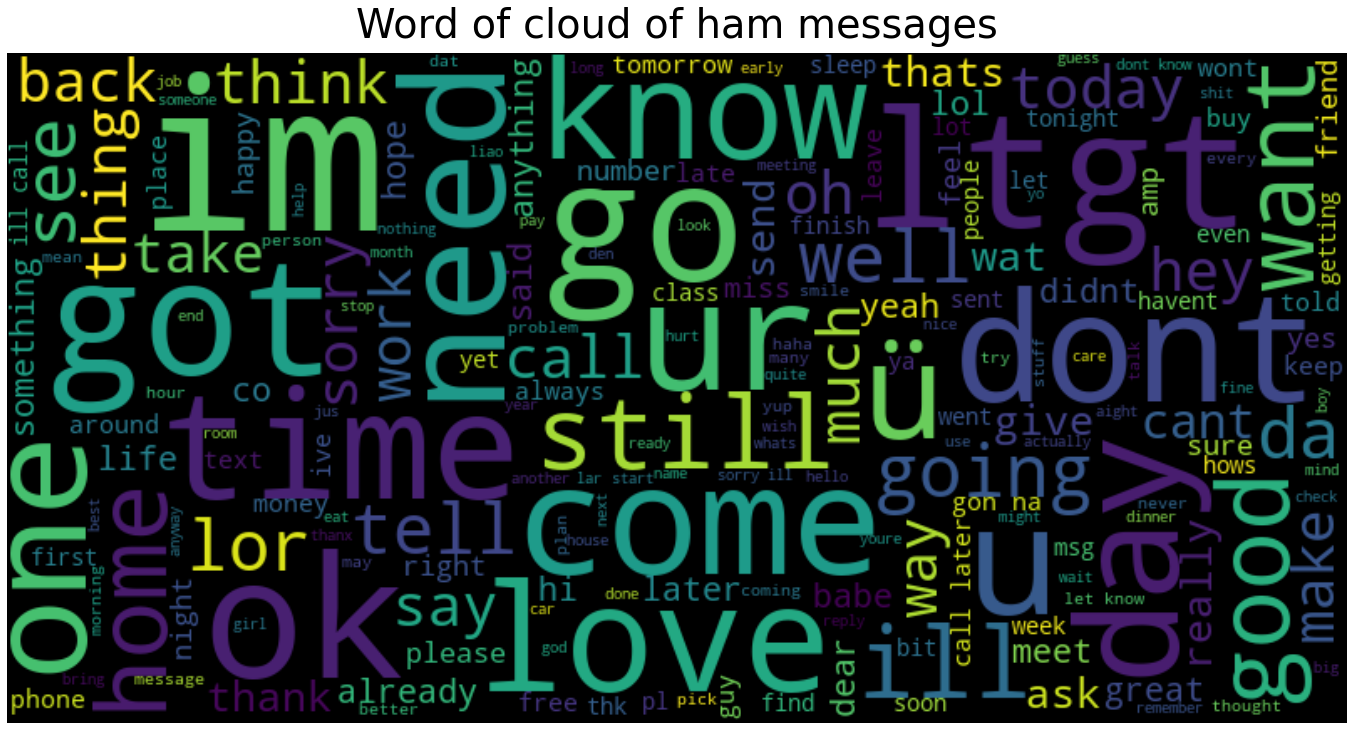

In [77]:
# create a text with all the messages
hamText2 = " ".join(review for review in ham_msg2.message) #df.message)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='black',
                    #stopwords = stopwords,
                    max_words = 200,
                    max_font_size = 125, 
                    random_state = 42,
                    width=800, 
                    height=400)
wordcloud.generate(str(hamText2))

# Display the generated image:
plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word of cloud of ham messages", fontdict={'size': 40, 'verticalalignment': 'bottom'})
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("img/first_review.png")

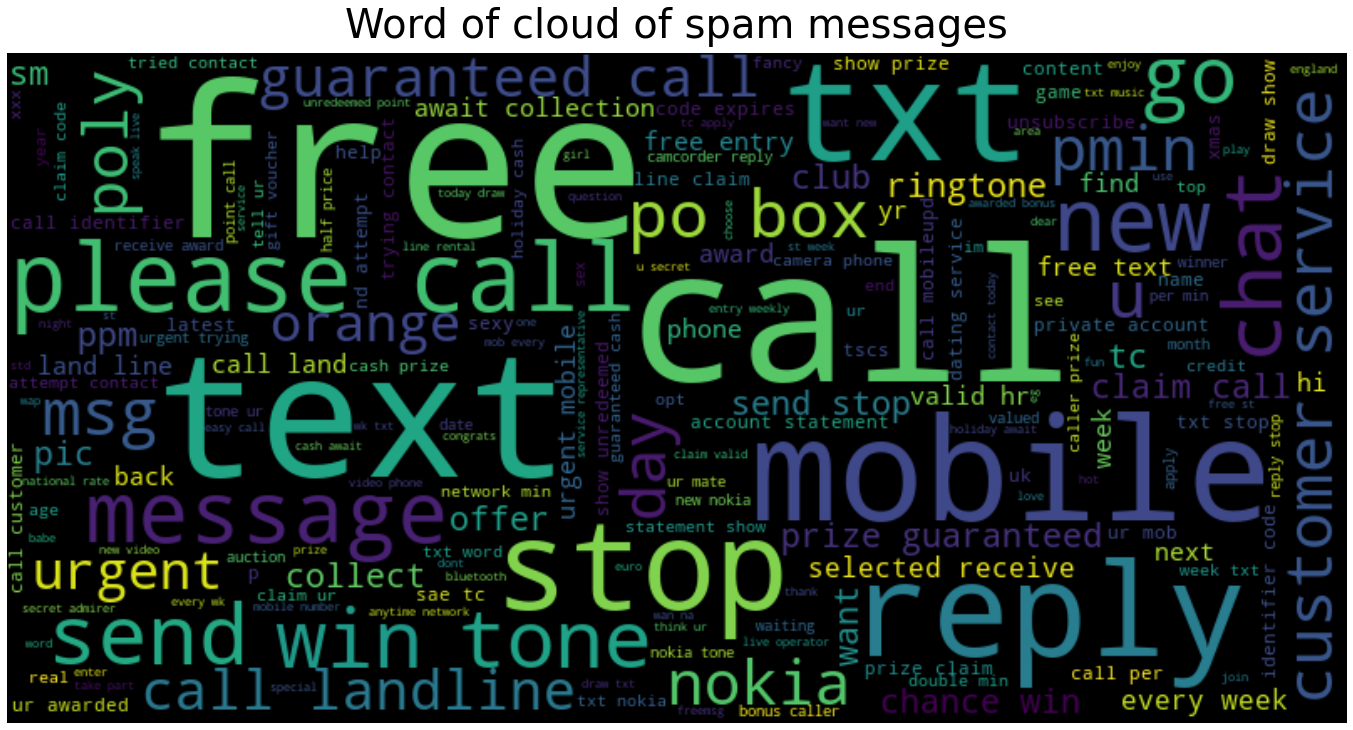

In [78]:
# create a text with all the messages
spamText2 = " ".join(review for review in spam_msg2.message) #df.message)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='black',
                    #stopwords = stopwords,
                    max_words = 200,
                    max_font_size = 125, 
                    random_state = 42,
                    width=800, 
                    height=400)
wordcloud.generate(str(spamText2))

# Display the generated image:
plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word of cloud of spam messages", fontdict={'size': 40, 'verticalalignment': 'bottom'})
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("img/first_review.png")

In [79]:
# create 2 subplots
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Frequent words of ham messages", 
                                                          "Frequent words of spam messages"])
fig.append_trace(go.Bar(
            y = create_df(ham_msg2.message, 1)["message"].head(30).values[::-1],
            x = create_df(ham_msg2.message, 1)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 1)
fig.append_trace(go.Bar(
            y = create_df(spam_msg2.message, 1)["message"].head(30).values[::-1],
            x = create_df(spam_msg2.message, 1)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 2)

fig['layout'].update(height=1200, width=900, title="Plots of words frequences",  title_x=0.5, title_y=0.96)
fig.show()
#py.iplot(fig)

#plt.figure(figsize=(10,16))
#plt.show()

C:\Users\remac\Anaconda3\envs\DL_projet\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [80]:
# create 2 subplots
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Bigram of frequent ham messages", 
                                                          "Bigram of frequent spam messages"])
fig.append_trace(go.Bar(
            y = create_df(ham_msg2.message, 2)["message"].head(30).values[::-1],
            x = create_df(ham_msg2.message, 2)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 1)
fig.append_trace(go.Bar(
            y = create_df(spam_msg2.message, 2)["message"].head(30).values[::-1],
            x = create_df(spam_msg2.message, 2)["number"].head(30).values[::-1],
            orientation = 'h',
            showlegend = False), 1, 2)

fig['layout'].update(height=1200, width=900, title="Bigrams of words frequences",  title_x=0.5, title_y=0.96)
fig.show()
#py.iplot(fig)

#plt.figure(figsize=(10,16))
#plt.show()

C:\Users\remac\Anaconda3\envs\DL_projet\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Feature selection

In [81]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### CountVectorizer()

Here : the data have been cleaned

Let's try to use CountVectorizer() to convert words to integers and then train with a simple model, LogisticRegression, to see how it performs.

In [84]:
msg_labels = (df2['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array

train_msg, test_msg, train_labels, test_labels = train_test_split(
                    df2.message, msg_labels, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(train_msg)

print("vocabulary size: ", len(vectorizer.vocabulary_))
#print(vectorizer.shape)

X_train = vectorizer.transform(train_msg)
X_test  = vectorizer.transform(test_msg)
X_train = X_train.toarray()
X_test  = X_test.toarray()

model = LogisticRegression()
model.fit(X_train, train_labels)
y_predict = model.predict(X_test)
  
# Use metrics.accuracy_score to measure the score
print("Accuracy %.3f" %metrics.accuracy_score(test_labels, y_predict))

vocabulary size:  6713
Accuracy 0.980


Let's compare to this performance to the original data, which haven't been cleaned up, with CountVectorizer().

In [86]:
msg_labels_try = (df['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array

train_msg_try, test_msg_try, train_labels_try, test_labels_try = train_test_split(
                    df.message, msg_labels_try, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()#stop_words=stopwords.words('english'))
vectorizer.fit(train_msg_try)

print("vocabulary size: ", len(vectorizer.vocabulary_))
#print(vectorizer.shape)

X_train_try = vectorizer.transform(train_msg_try)
X_test_try  = vectorizer.transform(test_msg_try)
X_train_try = X_train_try.toarray()
X_test_try  = X_test_try.toarray()

model_try = LogisticRegression()
model_try.fit(X_train_try, train_labels_try)
y_predict_try = model_try.predict(X_test_try)
  
# Use metrics.accuracy_score to measure the score
print("Accuracy %.3f" %metrics.accuracy_score(test_labels_try, y_predict_try))

vocabulary size:  7461
Accuracy 0.983


### TfidfVectorizer()

The TfidfVectorizer tokenize documents, learn the vocabulary and inverse document frequency weightings. It allows to encode new documents. 

In [87]:
msg_labels = (df2['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array

train_msg, test_msg, train_labels, test_labels = train_test_split(
                    df2.message, msg_labels, test_size=0.25, random_state=1000)

vectorizer = TfidfVectorizer() # stop_words=stopwords.words('english')
vectorizer.fit(train_msg)

print("vocabulary size: ", len(vectorizer.vocabulary_))
#print(vectorizer.shape)

X_train = vectorizer.transform(train_msg)
X_test  = vectorizer.transform(test_msg)
X_train = X_train.toarray()
X_test  = X_test.toarray()

model = LogisticRegression()
model.fit(X_train, train_labels)
y_predict = model.predict(X_test)
  
# Use metrics.accuracy_score to measure the score
print("Accuracy %.3f" %metrics.accuracy_score(test_labels, y_predict))

vocabulary size:  6713
Accuracy 0.965


### TextVectorization()

Let's try TextVectorization(). Keras offers this tool to create a layer that we will add to our model. This layer converts the text to integer sequences.

This layer can preprocess the data : text normalization, text standardization, tokenization, n-gram generation, and vocabulary indexing.

In [88]:
vocab_size = 500
max_len = 50 # Max number of tokens

vectorize_layer = TextVectorization(
  standardize=clean_data,
  max_tokens=vocab_size,
  output_mode='int',
  output_sequence_length=max_len)


In [89]:
msg_labels = (df2['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array

train_msg, test_msg, train_labels, test_labels = train_test_split(
                    df.message, msg_labels, test_size=0.25, random_state=1000)

#X_train = np.array(train_msg)
#X_test  = np.array(test_msg)

#### It doesn't work but I don't why

In [90]:
X_train = train_msg.map(lambda x, y: x)
vectorize_layer.adapt(X_train)

TypeError: <lambda>() missing 1 required positional argument: 'y'

In [91]:
embedding_dim = 100

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(vocab_size + 1, embedding_dim))

TypeError: expected string or bytes-like object

#### Some idea that would be interesting to explore further
Maybe check if it could be better without cleaning the data and by only using the available parameters of CounVectorizer() and TfifdVectorizer()

Understand why TextVectorization doens't work

Using pre-trained embedding such as glove

# Word embedding of Keras: a first test

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding # keras.layers.embeddings marche pas 

Embedding, arguments : vocabulary size,
   number of dimensions m in the embedding space represented by the Embedding layer,
   the length n of each padded sequence
 
Flatten : flattens the 2D output into a 1D array suitable for input to a Dense layer

Dense layer : classifies the values emitted from the flatten layer, changing the number of neurons in the dense layer tends to maximize accuracy

In [93]:
vocab_size = 500
max_len = 50

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            16000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 221,057
Trainable params: 221,057
Non-trainable params: 0
_________________________________________________________________


If we only have a few hundred training samples, the embedding layer might not have enough information to properly vectorize the corpus of text. In that case, we can use pretrained word embeddings, but a network trained to classify text usually performs better when word embeddings are learned from the training data because such embeddings are task-specific. 

on va se servir de training_padded

In [95]:
#hist = model.fit(training_padded, train_labels, validation_split=0.2, epochs=5, batch_size=20)

Graphically represent the accuracy of learning and validation for each epoch.

In [33]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()